# Imports

In [35]:
from optlang import Model, Variable, Constraint, Objective
import pandas as pd
from energizer.io import read_all_files
from energizer.vis import transform_df_to_gdf, plot_static_choropleth_map
from pathlib import Path
import matplotlib.pyplot as plt

# Analyzing the Data

In [36]:
df = read_all_files(sample=True)
df.head()

trip_id  taxi_id trip_start_timestamp  trip_end_timestamp  \
2748594  2748594      177  2013-05-18 20:00:00 2013-05-18 20:00:00   
6221783  6221783     2145  2013-10-11 10:15:00 2013-10-11 10:15:00   
3154610  3154610     1380  2013-06-06 14:45:00 2013-06-06 15:15:00   
7832169  7832169      686  2013-12-04 21:45:00 2013-12-04 22:00:00   
7617358  7617358     2645  2013-11-26 11:00:00 2013-11-26 11:30:00   

         trip_seconds  trip_miles   fare  tips  tolls  extras  trip_total  \
2748594         420.0         1.3   6.45  0.00    0.0     1.5        7.95   
6221783         300.0         1.3   6.05  0.00    0.0     1.0        7.05   
3154610        2220.0        11.3  26.25  5.65    0.0     2.0       33.90   
7832169         480.0         1.7   7.45  2.00    0.0     0.0        9.45   
7617358        1920.0        18.6  39.04  0.00    0.0     3.5       42.54   

        payment_type  pickup_census_tract  pickup_community_area  \
2748594         Cash         1.703132e+10                   32.0   
6221783         Cash         1.703132e+10                   32.0   
3154610  Credit Card         1.703184e+10                   32.0   
7832169  Credit Card         1.703132e+10                   32.0   
7617358         Cash         1.703108e+10                    8.0   

         pickup_centroid_latitude  pickup_centroid_longitude  \
2748594                 41.884987                 -87.620993   
6221783                 41.884987                 -87.620993   
3154610                 41.880994                 -87.632746   
7832169                 41.877406                 -87.621972   
7617358                 41.892508                 -87.626215   

                                  pickup_centroid_location  \
2748594  {'coordinates': [-87.6209929134, 41.8849871918...   
6221783  {'coordinates': [-87.6209929134, 41.8849871918...   
3154610  {'coordinates': [-87.6327464887, 41.8809944707...   
7832169  {'coordinates': [-87.6219716519, 41.8774061234...   
7617358  {'coordinates': [-87.6262149064, 41.8925077809...   

         dropoff_community_area  dropoff_centroid_latitude  \
2748594                     8.0                  41.891972   
6221783                    32.0                  41.870607   
3154610                    56.0                  41.785999   
7832169                     8.0                  41.890922   
7617358                    76.0                  41.979071   

         dropoff_centroid_longitude  \
2748594                  -87.612945   
6221783                  -87.622173   
3154610                  -87.750934   
7832169                  -87.618868   
7617358                  -87.903040   

                                 dropoff_centroid_location  \
2748594  {'coordinates': [-87.6129454143, 41.8919715078...   
6221783  {'coordinates': [-87.6221729369, 41.8706073724...   
3154610  {'coordinates': [-87.7509342894, 41.785998518]...   
7832169  {'coordinates': [-87.6188683546, 41.8909220259...   
7617358  {'coordinates': [-87.9030396611, 41.9790708201...   

         dropoff_census_tract                    company  humidity  \
2748594          1.703108e+10                       None      28.0   
6221783          1.703132e+10  Dispatch Taxi Affiliation      71.0   
3154610          1.703198e+10                       None      42.0   
7832169          1.703108e+10                       None      96.0   
7617358          1.703198e+10                       None      89.0   

         temperature  
2748594        17.01  
6221783        12.24  
3154610        19.62  
7832169        12.07  
7617358         0.12

Text(0.5, 0, 'Month')

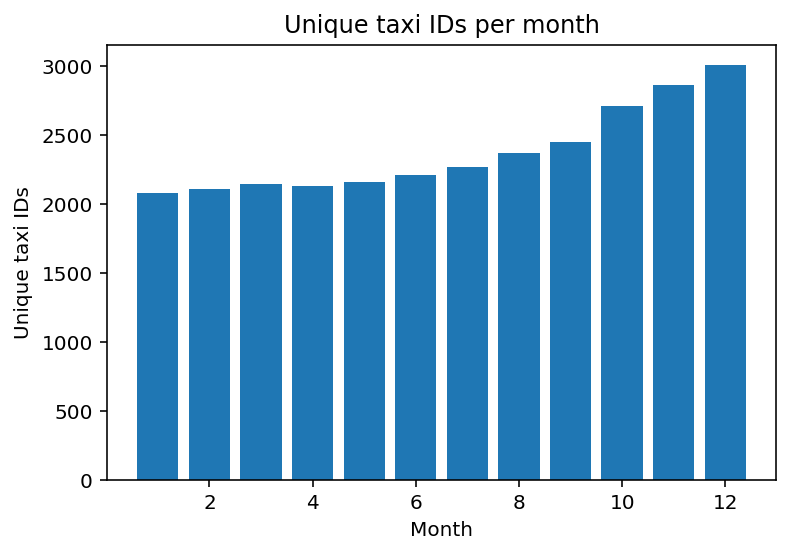

In [37]:
df['start_month'] = df['trip_start_timestamp'].dt.month
grouped = df.groupby('start_month').taxi_id.nunique()
fig, ax = plt.subplots()
ax.bar(x=grouped.index, height=grouped)
ax.set_title('Unique taxi IDs per month')
ax.set_ylabel('Unique taxi IDs')
ax.set_xlabel('Month')

The calculation for the allocation of future charging stations will be done on December,
as it is the month with the most registered taxis, thus having the best representative
data for future planning, as we are limited to 2013.
A possible theory could be, that since the earliest available data is from 2013,
the data collection started close to the beginning of that year and not all taxis
were immediately accounted for, or equipped with the necessary tools for the data collection
process.

# Get the trip data for December for each hexagon

In [38]:
data_dir = Path("../../data/input/hexagons/hex_res_8/trip_data4.parquet")
df_raw = pd.read_parquet(data_dir)[['trip_start_timestamp',
                                'trip_miles',
                                'hex_ID_pickup',
                                    'taxi_id']]

In [39]:
print('There were %s unique taxis in december' %len(df_raw.taxi_id.unique()))
df_raw.drop(columns=['taxi_id'], inplace=True)

There were 3107 unique taxis in december


In [40]:
df_raw = df_raw[df_raw.trip_start_timestamp >= '2013-12-01']
df_raw.reset_index(inplace=True, drop=True)

In [41]:
df = df_raw.groupby('hex_ID_pickup').sum()

## Needed variables
The customizable variables that constrain the linear program that optimizes
the amount and allocation of stations

In [42]:
total_miles = round(df.trip_miles.sum())
total_districts = len(df.index)
charging_time_per_mile = 0.35 # in minutes
min_allowed_workload = 0.2 # in percent from 0 to 1
budget = 1370000 # in the same currency as cost_per_station
cost_per_station = 6000 # in the same currency as budget

# Optimal number of stations
The first LP optimizes the total number of charging stations, by taking the budget
as well as the maximum allowed workload into account.

The result is then used for the allocation optimization.

In [43]:
s = Variable('stations', lb=0, type='integer')

budget_constraint = Constraint(s, ub=budget/cost_per_station)
workload_constraint = Constraint((s*44640),
                                 ub=((total_miles*charging_time_per_mile)*
                                    (1/min_allowed_workload)),
                                 # lb=(total_miles*charging_time_per_mile)
                                 )
opt_stations_obj = Objective(s, direction='max')

station_model = Model(name='Optimal Stations')
station_model.objective = opt_stations_obj
station_model.add([budget_constraint, workload_constraint])

status = station_model.optimize()

print("status:", station_model.status)
print("objective value:", station_model.objective.value)

for var_name, var in station_model.variables.iteritems():
    print(var_name, " = ", var.primal)


status: optimal
objective value: 103.0
stations  =  103.0


# Optimal allocation
The second LP allocates the charging stations to the hexagons by maximizing the
number of placed stations, while each hexagon is constrained by its share of
trip miles.

In [44]:
df.head()

# for index, row in df.iterrows():
#     print(type(row.trip_miles))

trip_miles
hex_ID_pickup              
8826645219fffff   116027.52
882664c101fffff    25415.11
882664c103fffff    16597.10
882664c105fffff    31927.67
882664c107fffff    23773.96

In [45]:
stations = station_model.variables.stations.primal

variables = []
constraints = []
upper_bounds_coef = {}
for index, row in df.iterrows():
    # define variable
    # append
    variables.append(Variable(index, lb=0, type='integer'))

    # define constraints
    upper_bounds_coef[index] = stations*(row.trip_miles / total_miles)

    # append
    constraints.append(Constraint(variables[-1],
                                  name='constraint_' + index,
                                  ub=max(1, upper_bounds_coef[index])))

constraint_station_sum = Constraint(sum(variables), ub=stations)
constraints.append(constraint_station_sum)

obj = Objective(sum(variable * upper_bounds_coef[variable.name] for variable in variables), direction='max')

allocation_model = Model(name='Allocation model')
allocation_model.objective = obj
allocation_model.add(constraints)

status = allocation_model.optimize()

print("status:", allocation_model.status)
print("objective value:", allocation_model.objective.value)

df['stations'] = 0
for var_name, var in allocation_model.variables.iteritems():
    df.loc[var_name, 'stations'] = var.primal

status: optimal
objective value: 738.966079441657


# Visualization
We then plot the allocated charging stations for each hexagon.

In [46]:
df.head()

trip_miles  stations
hex_ID_pickup                        
8826645219fffff   116027.52         4
882664c101fffff    25415.11         1
882664c103fffff    16597.10         1
882664c105fffff    31927.67         1
882664c107fffff    23773.96         1

In [47]:
gdf = transform_df_to_gdf(df)
gdf.head()


trip_miles  stations  \
hex_ID_pickup                           
8826645219fffff   116027.52         4   
882664c101fffff    25415.11         1   
882664c103fffff    16597.10         1   
882664c105fffff    31927.67         1   
882664c107fffff    23773.96         1   

                                                          geometry  
hex_ID_pickup                                                       
8826645219fffff  POLYGON ((-87.75063 41.79133, -87.75665 41.789...  
882664c101fffff  POLYGON ((-87.63804 41.93652, -87.64408 41.934...  
882664c103fffff  POLYGON ((-87.63329 41.92902, -87.63933 41.927...  
882664c105fffff  POLYGON ((-87.64948 41.93756, -87.65553 41.935...  
882664c107fffff  POLYGON ((-87.64473 41.93006, -87.65078 41.928...

No handles with labels found to put in legend.


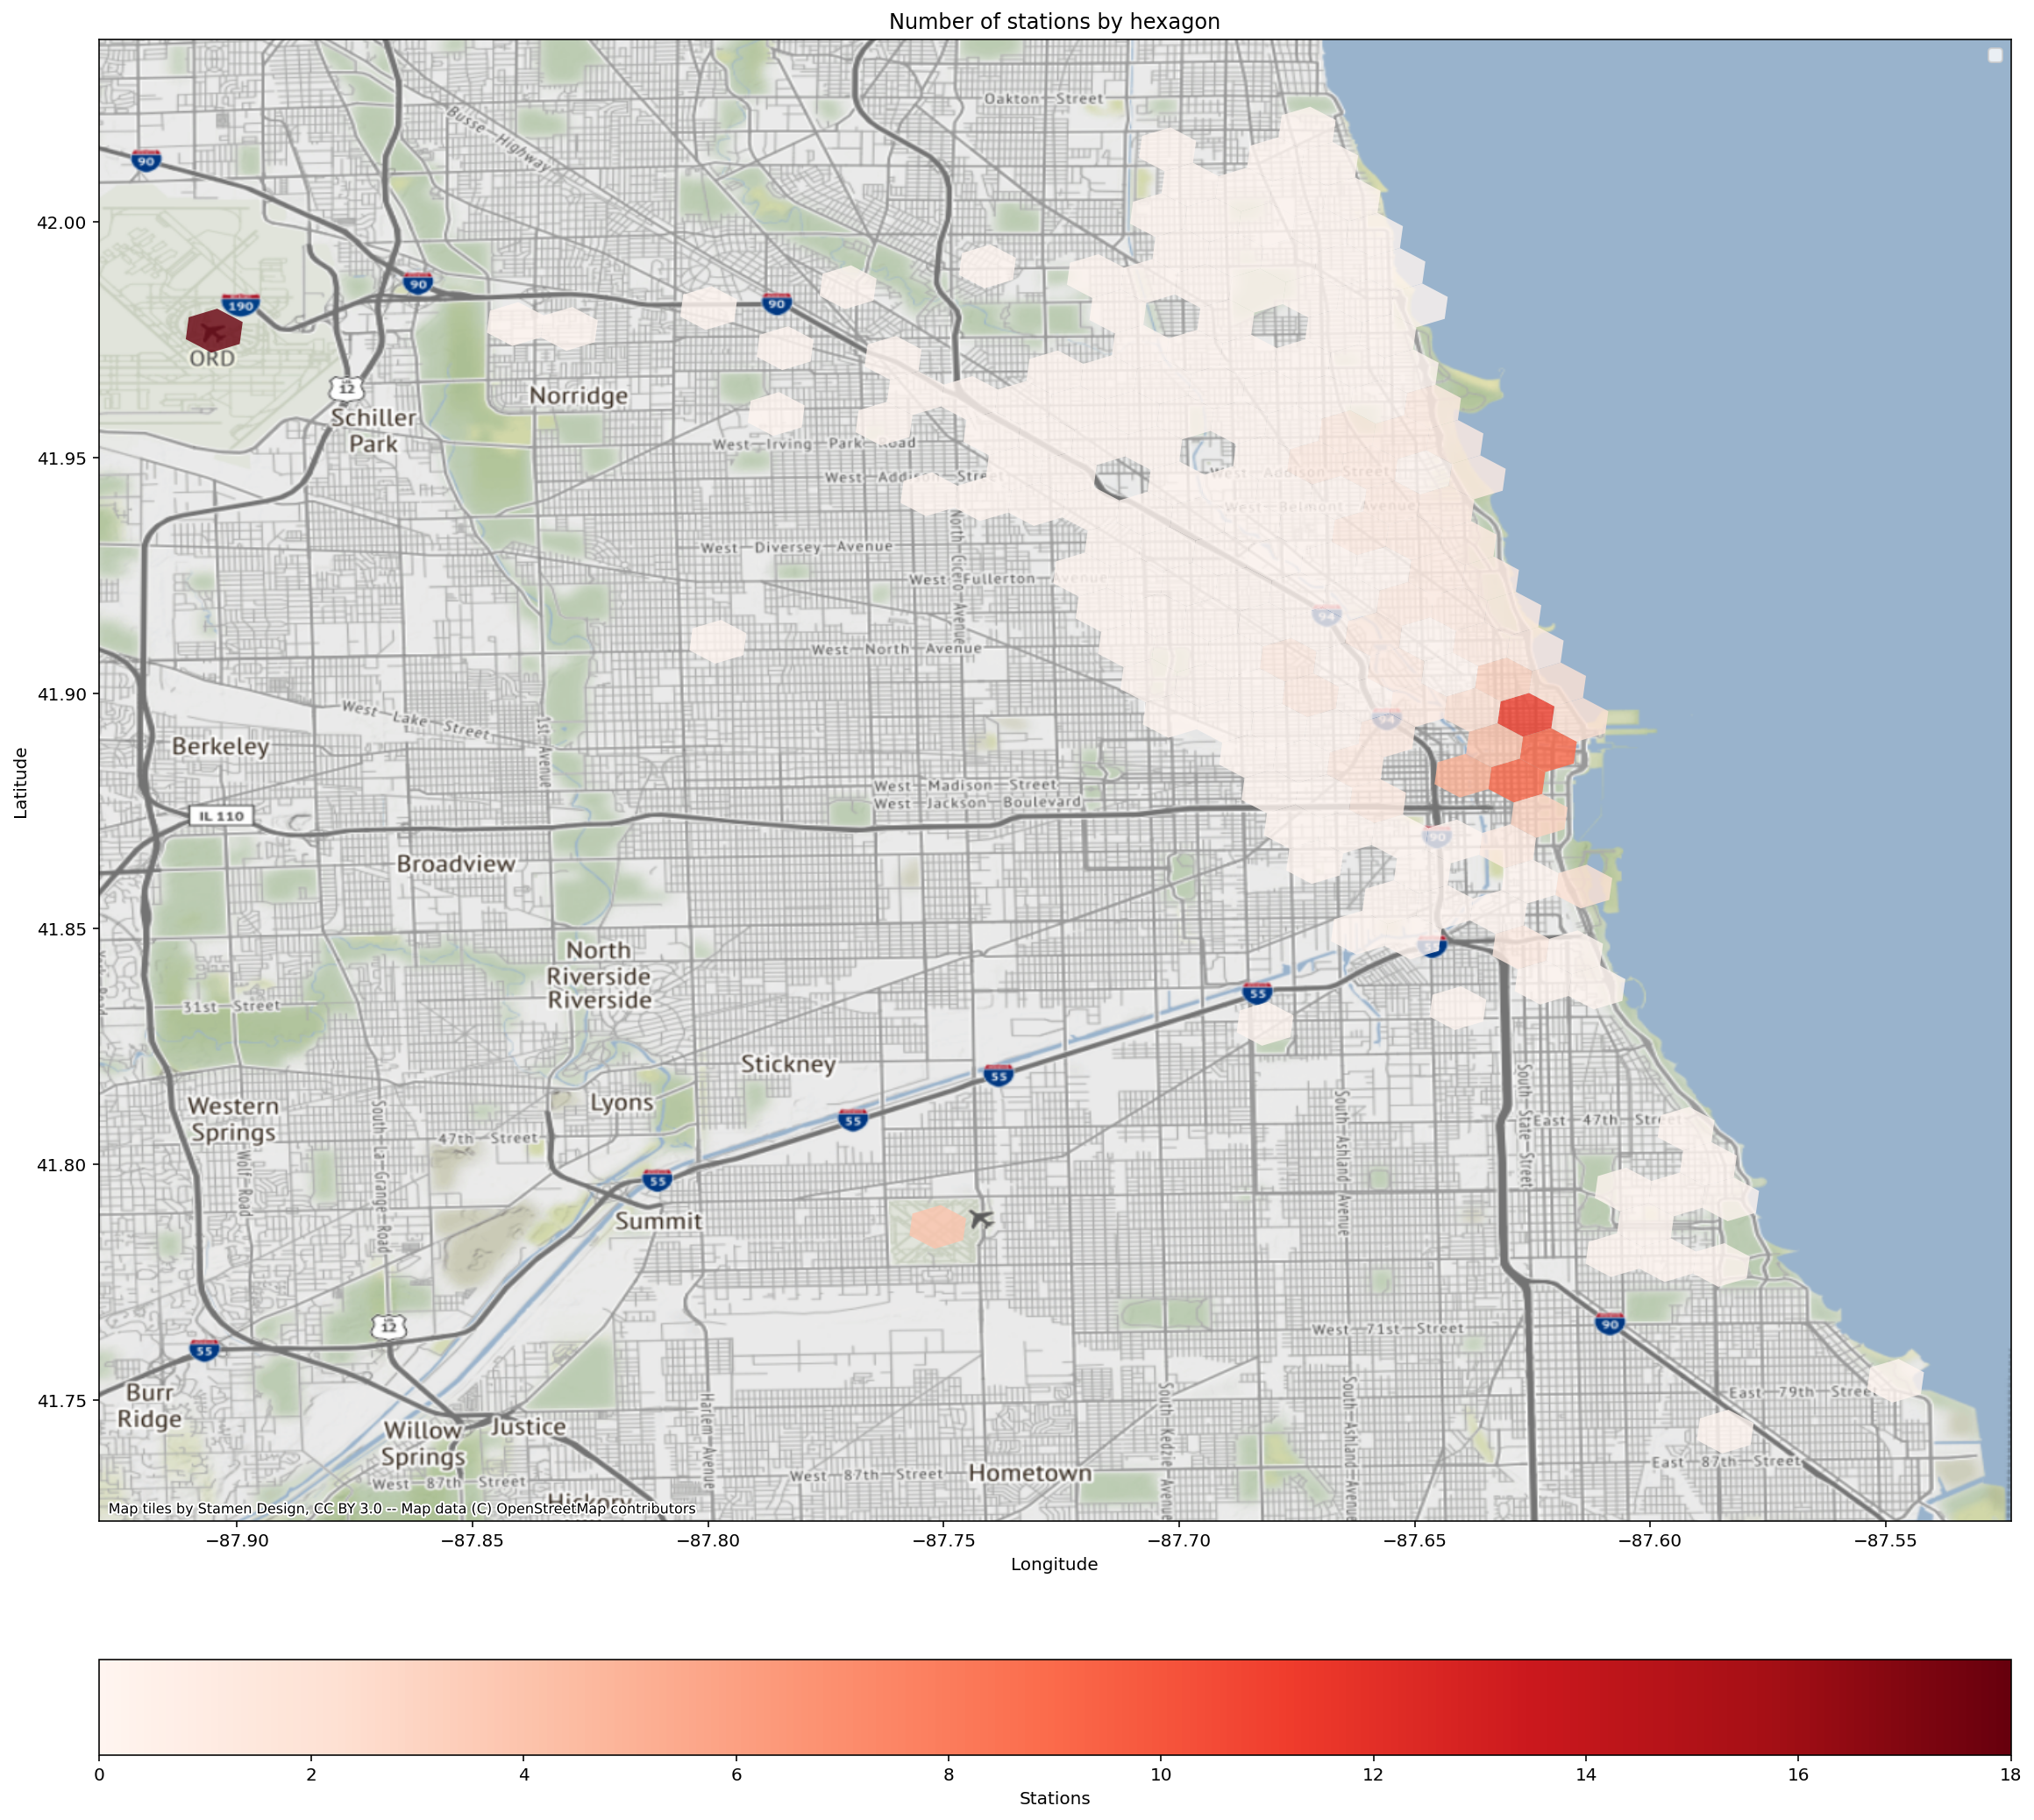

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 16), constrained_layout=True)
plot_static_choropleth_map(gdf, ax, 'Number of stations by hexagon', 'stations', 'Stations')